# **No Show Appointmnet Predictor**
---

Dataset is taken from [kaggle](https://www.kaggle.com/joniarroba/noshowappointments)

### **Import Libraries**

In [0]:
import pandas as pd
import numpy as np
import math
from pandas import DataFrame
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import pickle


import xgboost

In [0]:
# Load data
data_path = "no-show-appintment-predictor-data.csv"
df = pd.read_csv(data_path)

In [9]:
# Grab a peek at the data
df.head(10)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No
5,9.598513e+13,5626772,F,2016-04-27T08:36:51Z,2016-04-29T00:00:00Z,76,REPÚBLICA,0,1,0,0,0,0,No
6,7.336882e+14,5630279,F,2016-04-27T15:05:12Z,2016-04-29T00:00:00Z,23,GOIABEIRAS,0,0,0,0,0,0,Yes
7,3.449833e+12,5630575,F,2016-04-27T15:39:58Z,2016-04-29T00:00:00Z,39,GOIABEIRAS,0,0,0,0,0,0,Yes
8,5.639473e+13,5638447,F,2016-04-29T08:02:16Z,2016-04-29T00:00:00Z,21,ANDORINHAS,0,0,0,0,0,0,No
9,7.812456e+13,5629123,F,2016-04-27T12:48:25Z,2016-04-29T00:00:00Z,19,CONQUISTA,0,0,0,0,0,0,No


In [10]:
# Describe the shape of the data sample
print(df.shape)

(110527, 14)


In [11]:
#Check for duplicated records
sum(df.duplicated())

0

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [13]:
#Display the detailed information of each and every attributes
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
PatientId,110527.0,1.474963e+14,2.560949e+14,3.921784e+04,4.172614e+12,3.173184e+13,9.439172e+13,9.999816e+14
AppointmentID,110527.0,5.675305e+06,7.129575e+04,5.030230e+06,5.640286e+06,5.680573e+06,5.725524e+06,5.790484e+06
Age,110527.0,3.708887e+01,2.311020e+01,-1.000000e+00,1.800000e+01,3.700000e+01,5.500000e+01,1.150000e+02
Scholarship,110527.0,9.826558e-02,2.976748e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
Hipertension,110527.0,1.972459e-01,3.979213e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
Diabetes,110527.0,7.186479e-02,2.582651e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
Alcoholism,110527.0,3.039981e-02,1.716856e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
Handcap,110527.0,2.224796e-02,1.615427e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
SMS_received,110527.0,3.210256e-01,4.668727e-01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00


# **Data Cleaning**

In [14]:
#Convert date type column objects to datetime index
column_list = ['ScheduledDay', 'AppointmentDay']
for col in column_list:
  df[col] = pd.to_datetime(df[col])

#After converting, first five rows of the data
df.head(5)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [15]:
#Target variable('No-show') summary
df['No-show'].value_counts()

No     88208
Yes    22319
Name: No-show, dtype: int64

In [16]:
#Convert Target variable data values to 1 and 0
Enc = LabelEncoder()
df['No-show']=Enc.fit_transform(df['No-show'])
df['Gender']=Enc.fit_transform(df['Gender'])
#Target variable('No-show') summary
df['No-show'].value_counts()

0    88208
1    22319
Name: No-show, dtype: int64

In [17]:
#Extract the valid age rows
#Check for invalid age rows
df.query('Age < 0')

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
99832,4.659432e+14,5775010,0,2016-06-06 08:58:13+00:00,2016-06-06 00:00:00+00:00,-1,ROMÃO,0,0,0,0,0,0,0


In [0]:
#Drop the particular invalid row
df.drop(99832, inplace=True)

In [19]:
#Extract the valid age rows
#Check for invalid age rows
df.query('Age < 0')

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show


In [20]:
#Check for Handcap > 1
df.query('Handcap > 1')

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
946,7.282582e+13,5582483,1,2016-04-14 09:26:08+00:00,2016-04-29 00:00:00+00:00,94,BELA VISTA,0,1,1,0,2,1,0
1665,1.242919e+13,5525497,1,2016-03-30 09:16:41+00:00,2016-04-29 00:00:00+00:00,64,SANTA MARTHA,0,1,0,1,2,1,0
1666,1.242919e+13,5525498,1,2016-03-30 09:16:41+00:00,2016-04-29 00:00:00+00:00,64,SANTA MARTHA,0,1,0,1,2,0,0
2071,1.242919e+13,5640120,1,2016-04-29 10:08:48+00:00,2016-04-29 00:00:00+00:00,64,SANTA MARTHA,0,1,0,1,2,0,0
2091,1.491829e+13,5638626,0,2016-04-29 08:13:59+00:00,2016-04-29 00:00:00+00:00,11,ANDORINHAS,0,0,0,0,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108376,2.387212e+14,5756931,0,2016-06-01 08:48:28+00:00,2016-06-07 00:00:00+00:00,44,ROMÃO,0,1,1,0,2,1,0
109484,3.589495e+14,5752442,1,2016-05-31 11:45:57+00:00,2016-06-02 00:00:00+00:00,64,DA PENHA,0,1,1,0,2,0,0
109733,5.662976e+14,5772744,0,2016-06-03 16:11:00+00:00,2016-06-07 00:00:00+00:00,34,JUCUTUQUARA,0,0,0,0,2,1,0
109975,4.522185e+13,5766970,1,2016-06-02 16:07:36+00:00,2016-06-06 00:00:00+00:00,39,PRAIA DO SUÁ,1,0,0,0,2,1,0


In [21]:
#Drop Handcap > 1 rows
df.drop(df.query('Handcap > 1').index, inplace=True)
df.query('Handcap > 1')

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show


In [22]:
#Drop unwanted columns('PatientId','AppointmentID')
df.drop(['PatientId','AppointmentID'], axis = 1)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110327 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype              
---  ------          --------------   -----              
 0   PatientId       110327 non-null  float64            
 1   AppointmentID   110327 non-null  int64              
 2   Gender          110327 non-null  int64              
 3   ScheduledDay    110327 non-null  datetime64[ns, UTC]
 4   AppointmentDay  110327 non-null  datetime64[ns, UTC]
 5   Age             110327 non-null  int64              
 6   Neighbourhood   110327 non-null  object             
 7   Scholarship     110327 non-null  int64              
 8   Hipertension    110327 non-null  int64              
 9   Diabetes        110327 non-null  int64              
 10  Alcoholism      110327 non-null  int64              
 11  Handcap         110327 non-null  int64              
 12  SMS_received    110327 non-null  int64              
 13  No-show       

In [23]:
#Rename the column names by converting to lowercase and replace '-' by '_'
df.rename(columns=lambda x: x.lower().replace('-', '_'), inplace=True)

df.columns

Index(['patientid', 'appointmentid', 'gender', 'scheduledday',
       'appointmentday', 'age', 'neighbourhood', 'scholarship', 'hipertension',
       'diabetes', 'alcoholism', 'handcap', 'sms_received', 'no_show'],
      dtype='object')

In [24]:
#Calculate the date difference betweeb scheduled date and appointment date for future predictions
df['date_gap'] = abs(df.appointmentday - df.scheduledday).astype('timedelta64[D]')

df.columns
df.head(-5)

,patientid,appointmentid,gender,scheduledday,appointmentday,age,neighbourhood,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,no_show,date_gap
0,2.987250e+13,5642903,0,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,JARDIM DA PENHA,0,1,0,0,0,0,0,0.0
1,5.589978e+14,5642503,1,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,0,0,0,0,0,0,0.0
2,4.262962e+12,5642549,0,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62,MATA DA PRAIA,0,0,0,0,0,0,0,0.0
3,8.679512e+11,5642828,0,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8,PONTAL DE CAMBURI,0,0,0,0,0,0,0,0.0
4,8.841186e+12,5642494,0,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,1,1,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110517,5.574942e+12,5780122,0,2016-06-07 07:38:34+00:00,2016-06-07 00:00:00+00:00,19,MARIA ORTIZ,0,0,0,0,0,0,0,0.0
110518,7.263315e+13,5630375,0,2016-04-27 15:15:06+00:00,2016-06-07 00:00:00+00:00,50,MARIA ORTIZ,0,0,0,0,0,1,0,40.0
110519,6.542388e+13,5630447,0,2016-04-27 15:23:14+00:00,2016-06-07 00:00:00+00:00,22,MARIA ORTIZ,0,0,0,0,0,1,0,40.0
110520,9.969977e+14,5650534,0,2016-05-03 07:51:47+00:00,2016-06-07 00:00:00+00:00,42,MARIA ORTIZ,0,0,0,0,0,1,0,34.0


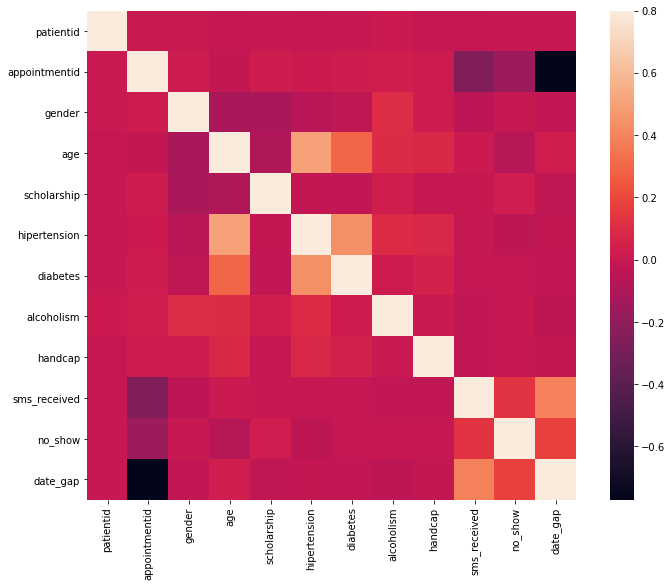

In [25]:
# Correlation matrix
corr_matrix = df.corr()
fig = plt.figure(figsize = (12,9))
sns.heatmap(corr_matrix, vmax = .8, square = True)
plt.show()

In [26]:
#Encoding data for machine learning modeling
#Creating vars to hold categorical features for one hot encoding
cat_features_for_encoding = ['handcap', 'neighbourhood']
encoded_df = pd.get_dummies(df, columns = cat_features_for_encoding)
encoded_df.head(5)

,patientid,appointmentid,gender,scheduledday,appointmentday,age,scholarship,hipertension,diabetes,alcoholism,sms_received,no_show,date_gap,handcap_0,handcap_1,neighbourhood_AEROPORTO,neighbourhood_ANDORINHAS,neighbourhood_ANTÔNIO HONÓRIO,neighbourhood_ARIOVALDO FAVALESSA,neighbourhood_BARRO VERMELHO,neighbourhood_BELA VISTA,neighbourhood_BENTO FERREIRA,neighbourhood_BOA VISTA,neighbourhood_BONFIM,neighbourhood_CARATOÍRA,neighbourhood_CENTRO,neighbourhood_COMDUSA,neighbourhood_CONQUISTA,neighbourhood_CONSOLAÇÃO,neighbourhood_CRUZAMENTO,neighbourhood_DA PENHA,neighbourhood_DE LOURDES,neighbourhood_DO CABRAL,neighbourhood_DO MOSCOSO,neighbourhood_DO QUADRO,neighbourhood_ENSEADA DO SUÁ,neighbourhood_ESTRELINHA,neighbourhood_FONTE GRANDE,neighbourhood_FORTE SÃO JOÃO,neighbourhood_FRADINHOS,...,neighbourhood_JOANA D´ARC,neighbourhood_JUCUTUQUARA,neighbourhood_MARIA ORTIZ,neighbourhood_MARUÍPE,neighbourhood_MATA DA PRAIA,neighbourhood_MONTE BELO,neighbourhood_MORADA DE CAMBURI,neighbourhood_MÁRIO CYPRESTE,neighbourhood_NAZARETH,neighbourhood_NOVA PALESTINA,neighbourhood_PARQUE INDUSTRIAL,neighbourhood_PARQUE MOSCOSO,neighbourhood_PIEDADE,neighbourhood_PONTAL DE CAMBURI,neighbourhood_PRAIA DO CANTO,neighbourhood_PRAIA DO SUÁ,neighbourhood_REDENÇÃO,neighbourhood_REPÚBLICA,neighbourhood_RESISTÊNCIA,neighbourhood_ROMÃO,neighbourhood_SANTA CECÍLIA,neighbourhood_SANTA CLARA,neighbourhood_SANTA HELENA,neighbourhood_SANTA LUÍZA,neighbourhood_SANTA LÚCIA,neighbourhood_SANTA MARTHA,neighbourhood_SANTA TEREZA,neighbourhood_SANTO ANDRÉ,neighbourhood_SANTO ANTÔNIO,neighbourhood_SANTOS DUMONT,neighbourhood_SANTOS REIS,neighbourhood_SEGURANÇA DO LAR,neighbourhood_SOLON BORGES,neighbourhood_SÃO BENEDITO,neighbourhood_SÃO CRISTÓVÃO,neighbourhood_SÃO JOSÉ,neighbourhood_SÃO PEDRO,neighbourhood_TABUAZEIRO,neighbourhood_UNIVERSITÁRIO,neighbourhood_VILA RUBIM
0,2.987250e+13,5642903,0,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,0,1,0,0,0,0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,5.589978e+14,5642503,1,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,0,0,0,0,0,0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,4.262962e+12,5642549,0,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62,0,0,0,0,0,0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,8.679512e+11,5642828,0,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8,0,0,0,0,0,0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,8.841186e+12,5642494,0,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56,0,1,1,0,0,0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [27]:
features = encoded_df.drop(['patientid', 'appointmentid', 'scheduledday','appointmentday','no_show'],axis=1)
labels = encoded_df['no_show']

print(labels.head())
features.head()

0    0
1    0
2    0
3    0
4    0
Name: no_show, dtype: int64


,gender,age,scholarship,hipertension,diabetes,alcoholism,sms_received,date_gap,handcap_0,handcap_1,neighbourhood_AEROPORTO,neighbourhood_ANDORINHAS,neighbourhood_ANTÔNIO HONÓRIO,neighbourhood_ARIOVALDO FAVALESSA,neighbourhood_BARRO VERMELHO,neighbourhood_BELA VISTA,neighbourhood_BENTO FERREIRA,neighbourhood_BOA VISTA,neighbourhood_BONFIM,neighbourhood_CARATOÍRA,neighbourhood_CENTRO,neighbourhood_COMDUSA,neighbourhood_CONQUISTA,neighbourhood_CONSOLAÇÃO,neighbourhood_CRUZAMENTO,neighbourhood_DA PENHA,neighbourhood_DE LOURDES,neighbourhood_DO CABRAL,neighbourhood_DO MOSCOSO,neighbourhood_DO QUADRO,neighbourhood_ENSEADA DO SUÁ,neighbourhood_ESTRELINHA,neighbourhood_FONTE GRANDE,neighbourhood_FORTE SÃO JOÃO,neighbourhood_FRADINHOS,neighbourhood_GOIABEIRAS,neighbourhood_GRANDE VITÓRIA,neighbourhood_GURIGICA,neighbourhood_HORTO,neighbourhood_ILHA DAS CAIEIRAS,...,neighbourhood_JOANA D´ARC,neighbourhood_JUCUTUQUARA,neighbourhood_MARIA ORTIZ,neighbourhood_MARUÍPE,neighbourhood_MATA DA PRAIA,neighbourhood_MONTE BELO,neighbourhood_MORADA DE CAMBURI,neighbourhood_MÁRIO CYPRESTE,neighbourhood_NAZARETH,neighbourhood_NOVA PALESTINA,neighbourhood_PARQUE INDUSTRIAL,neighbourhood_PARQUE MOSCOSO,neighbourhood_PIEDADE,neighbourhood_PONTAL DE CAMBURI,neighbourhood_PRAIA DO CANTO,neighbourhood_PRAIA DO SUÁ,neighbourhood_REDENÇÃO,neighbourhood_REPÚBLICA,neighbourhood_RESISTÊNCIA,neighbourhood_ROMÃO,neighbourhood_SANTA CECÍLIA,neighbourhood_SANTA CLARA,neighbourhood_SANTA HELENA,neighbourhood_SANTA LUÍZA,neighbourhood_SANTA LÚCIA,neighbourhood_SANTA MARTHA,neighbourhood_SANTA TEREZA,neighbourhood_SANTO ANDRÉ,neighbourhood_SANTO ANTÔNIO,neighbourhood_SANTOS DUMONT,neighbourhood_SANTOS REIS,neighbourhood_SEGURANÇA DO LAR,neighbourhood_SOLON BORGES,neighbourhood_SÃO BENEDITO,neighbourhood_SÃO CRISTÓVÃO,neighbourhood_SÃO JOSÉ,neighbourhood_SÃO PEDRO,neighbourhood_TABUAZEIRO,neighbourhood_UNIVERSITÁRIO,neighbourhood_VILA RUBIM
0,0,62,0,1,0,0,0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,56,0,0,0,0,0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,62,0,0,0,0,0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,8,0,0,0,0,0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,56,0,1,1,0,0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [28]:
#Scalling
stdsc = StandardScaler()
features_std = stdsc.fit_transform(features)
features_std 

array([[-0.73354432,  1.0792841 , -0.33013997, ..., -0.17079162,
        -0.03714328, -0.08795779],
       [ 1.36324414,  0.81952075, -0.33013997, ..., -0.17079162,
        -0.03714328, -0.08795779],
       [-0.73354432,  1.0792841 , -0.33013997, ..., -0.17079162,
        -0.03714328, -0.08795779],
       ...,
       [-0.73354432, -0.69576545, -0.33013997, ..., -0.17079162,
        -0.03714328, -0.08795779],
       [-0.73354432,  0.04023071, -0.33013997, ..., -0.17079162,
        -0.03714328, -0.08795779],
       [-0.73354432,  0.73293297, -0.33013997, ..., -0.17079162,
        -0.03714328, -0.08795779]])

In [0]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features_std, labels, test_size = 0.2, random_state = 1, stratify = labels)

In [0]:
#Common function to display scores of model for a given train/test data
def modelscores(model, x_train,x_test, y_train, y_test, x_std, y_out):
  scores = cross_val_score(estimator=model, X=x_std, y=y_out, cv = 10, n_jobs = 1)
  print('CV Accuracy : %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))
  model.fit(x_train, y_train)
  print('Accuracy: %.3f' % model.score(x_test, y_test))


### Logistic Regression Esimator

In [31]:
pipe_lr = make_pipeline(PCA(), LogisticRegression(random_state=0))
print(pipe_lr.get_params().keys())
param_range = [.1, .5, 1, 10]


def lrpca(x_train, y_train):
  n_components = np.arange(7,x_train.shape[1]+1,1)
  param_grid = [{'pca__n_components': n_components, 'logisticregression__C': param_range}]
  grid_search_lr = GridSearchCV(estimator=pipe_lr, param_grid=param_grid, scoring='accuracy', cv = 10)

  grid_search_lr.fit(x_train, y_train)
  print('*********Logistic Regression*********')
  print('The best score: %.3f' % (grid_search_lr.best_score_))
  print('The best params: ', grid_search_lr.best_params_)

  lreg_best = grid_search_lr.best_estimator_
  return lreg_best


lr_bestmodel = lrpca(train_features, train_labels)

dict_keys(['memory', 'steps', 'verbose', 'pca', 'logisticregression', 'pca__copy', 'pca__iterated_power', 'pca__n_components', 'pca__random_state', 'pca__svd_solver', 'pca__tol', 'pca__whiten', 'logisticregression__C', 'logisticregression__class_weight', 'logisticregression__dual', 'logisticregression__fit_intercept', 'logisticregression__intercept_scaling', 'logisticregression__l1_ratio', 'logisticregression__max_iter', 'logisticregression__multi_class', 'logisticregression__n_jobs', 'logisticregression__penalty', 'logisticregression__random_state', 'logisticregression__solver', 'logisticregression__tol', 'logisticregression__verbose', 'logisticregression__warm_start'])
*********Logistic Regression*********
The best score: 0.798
The best params:  {'logisticregression__C': 10, 'pca__n_components': 17}


In [0]:
# Save the model using pickle
file_name_lr = "G:\\SLIIT\\OFFICIAL\\ML\\Assignment1\\no-show-appintment-predictor\\trainedModel\\logistic_regression_estimator_best.sav"
pickle.dump(lr_bestmodel, open(file_name_lr, 'wb'))

In [33]:
# Load the saved model to do the predictions
model_loaded_lr = pickle.load(open(file_name_lr, 'rb'))
modelscores(model_loaded_lr, train_features, test_features, train_labels, test_labels, features_std, labels)

CV Accuracy : 0.797 +/- 0.001
Accuracy: 0.797


Text(91.68, 0.5, 'predicted class')

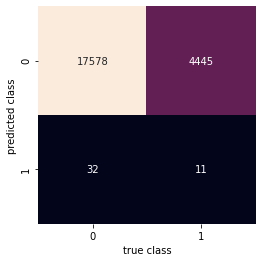

In [46]:
lr_predict = model_loaded_lr.predict(test_features)

from sklearn.metrics import confusion_matrix 
mat = confusion_matrix(test_labels, lr_predict)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False) 
plt.xlabel('true class') 
plt.ylabel('predicted class')

In [47]:
from sklearn import metrics
print("Classification Report : \n\n", metrics.classification_report(lr_predict, test_labels))

Classification Report : 

               precision    recall  f1-score   support

           0       1.00      0.80      0.89     22023
           1       0.00      0.26      0.00        43

    accuracy                           0.80     22066
   macro avg       0.50      0.53      0.45     22066
weighted avg       1.00      0.80      0.89     22066



## Random Forest Estimator

In [34]:
forest = RandomForestClassifier(random_state=1)

param_grid = { 'n_estimators':[5,10,25,50], 'max_features':['auto', 'sqrt', 'log2'], 'max_depth':[2,3,4,5,6,7,8], 'criterion':['gini', 'entropy']}
grid_search_rf = GridSearchCV(estimator=forest, param_grid=param_grid, scoring='accuracy', cv = 10, n_jobs=2)

grid_search_rf = grid_search_rf.fit(train_features, train_labels)
print('*********Random Forest*********')
print('The best score: %.3f' % (grid_search_rf.best_score_))
print('The best params: ', grid_search_rf.best_params_)
print('*******************************')

*********Random Forest*********
The best score: 0.798
The best params:  {'criterion': 'entropy', 'max_depth': 7, 'max_features': 'log2', 'n_estimators': 5}
*******************************


In [0]:
grid_search_rf_best = grid_search_rf.best_estimator_

In [0]:
file_name_rf = "G:\\SLIIT\\OFFICIAL\\ML\\Assignment1\\no-show-appintment-predictor\\trainedModel\\random_forest_estimator_best.sav"
pickle.dump(grid_search_rf_best, open(file_name_rf, 'wb'))

In [37]:
# Load the saved model to do the predictions
model_loaded_rf = pickle.load(open(file_name_rf, 'rb'))
modelscores(model_loaded_rf, train_features, test_features, train_labels, test_labels, features_std, labels)

CV Accuracy : 0.798 +/- 0.000
Accuracy: 0.798


Text(91.68, 0.5, 'predicted class')

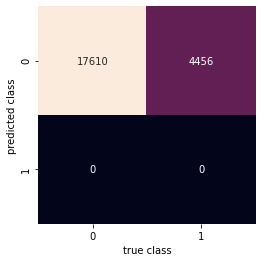

In [43]:
rf_predict = model_loaded_rf.predict(test_features)

from sklearn.metrics import confusion_matrix 
mat = confusion_matrix(test_labels, rf_predict)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False) 
plt.xlabel('true class') 
plt.ylabel('predicted class')


In [48]:
from sklearn import metrics
print("Classification Report : \n\n", metrics.classification_report(rf_predict, test_labels))

Classification Report : 

               precision    recall  f1-score   support

           0       1.00      0.80      0.89     22066
           1       0.00      0.00      0.00         0

    accuracy                           0.80     22066
   macro avg       0.50      0.40      0.44     22066
weighted avg       1.00      0.80      0.89     22066



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## AdaBoost using Tree Trumps

In [38]:
tree_stump = DecisionTreeClassifier(criterion='entropy', random_state=1, max_depth=1)
ada = AdaBoostClassifier(base_estimator=tree_stump, n_estimators=500, random_state=1)

tree_stump = tree_stump.fit(train_features, train_labels)

y_train_pred = tree_stump.predict(train_features)
y_test_pred = tree_stump.predict(test_features)

tree_train = accuracy_score(train_labels, y_train_pred)
tree_test = accuracy_score(test_labels, y_test_pred)

print('Decision tree train/test accuracies %.3f/%.3f' % (tree_train, tree_test))

Decision tree train/test accuracies 0.798/0.798


In [39]:
def adaModel(x_train, y_train):
  param_grid = [{'learning_rate':[0.05,0.1,0.2]}]
  grid_search_ada = GridSearchCV(estimator=ada, param_grid=param_grid, scoring='accuracy', cv = 10)

  grid_search_ada.fit(x_train, y_train)
  print('*********For AdaBoost using Tree Trumps*********')
  print('The best score: %.3f' % (grid_search_ada.best_score_))
  print('The best params: ', grid_search_ada.best_params_)

  ada_best = grid_search_ada.best_estimator_
  return ada_best

ada_bestmodel = adaModel(train_features, train_labels)

*********For AdaBoost using Tree Trumps*********
The best score: 0.798
The best params:  {'learning_rate': 0.1}


In [0]:
file_name_ada = "G:\\SLIIT\\OFFICIAL\\ML\\Assignment1\\no-show-appintment-predictor\\trainedModel\\ada_boost_estimator_best.sav"
pickle.dump(ada_bestmodel, open(file_name_ada, 'wb'))

In [41]:
# Load the saved model to do the predictions
model_loaded_ada = pickle.load(open(file_name_ada, 'rb'))
modelscores(model_loaded_ada, train_features, test_features, train_labels, test_labels, features_std, labels)

CV Accuracy : 0.797 +/- 0.002
Accuracy: 0.798


Text(91.68, 0.5, 'predicted class')

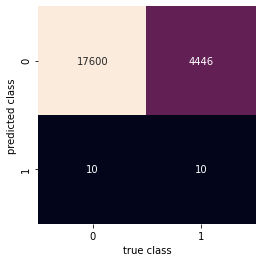

In [45]:
ada_predict = model_loaded_ada.predict(test_features)

from sklearn.metrics import confusion_matrix 
mat = confusion_matrix(test_labels, ada_predict)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False) 
plt.xlabel('true class') 
plt.ylabel('predicted class')

In [49]:
from sklearn import metrics
print("Classification Report : \n\n", metrics.classification_report(ada_predict, test_labels))

Classification Report : 

               precision    recall  f1-score   support

           0       1.00      0.80      0.89     22046
           1       0.00      0.50      0.00        20

    accuracy                           0.80     22066
   macro avg       0.50      0.65      0.45     22066
weighted avg       1.00      0.80      0.89     22066

